# Radial Order with all 10 Runs

## First Calculate the difference

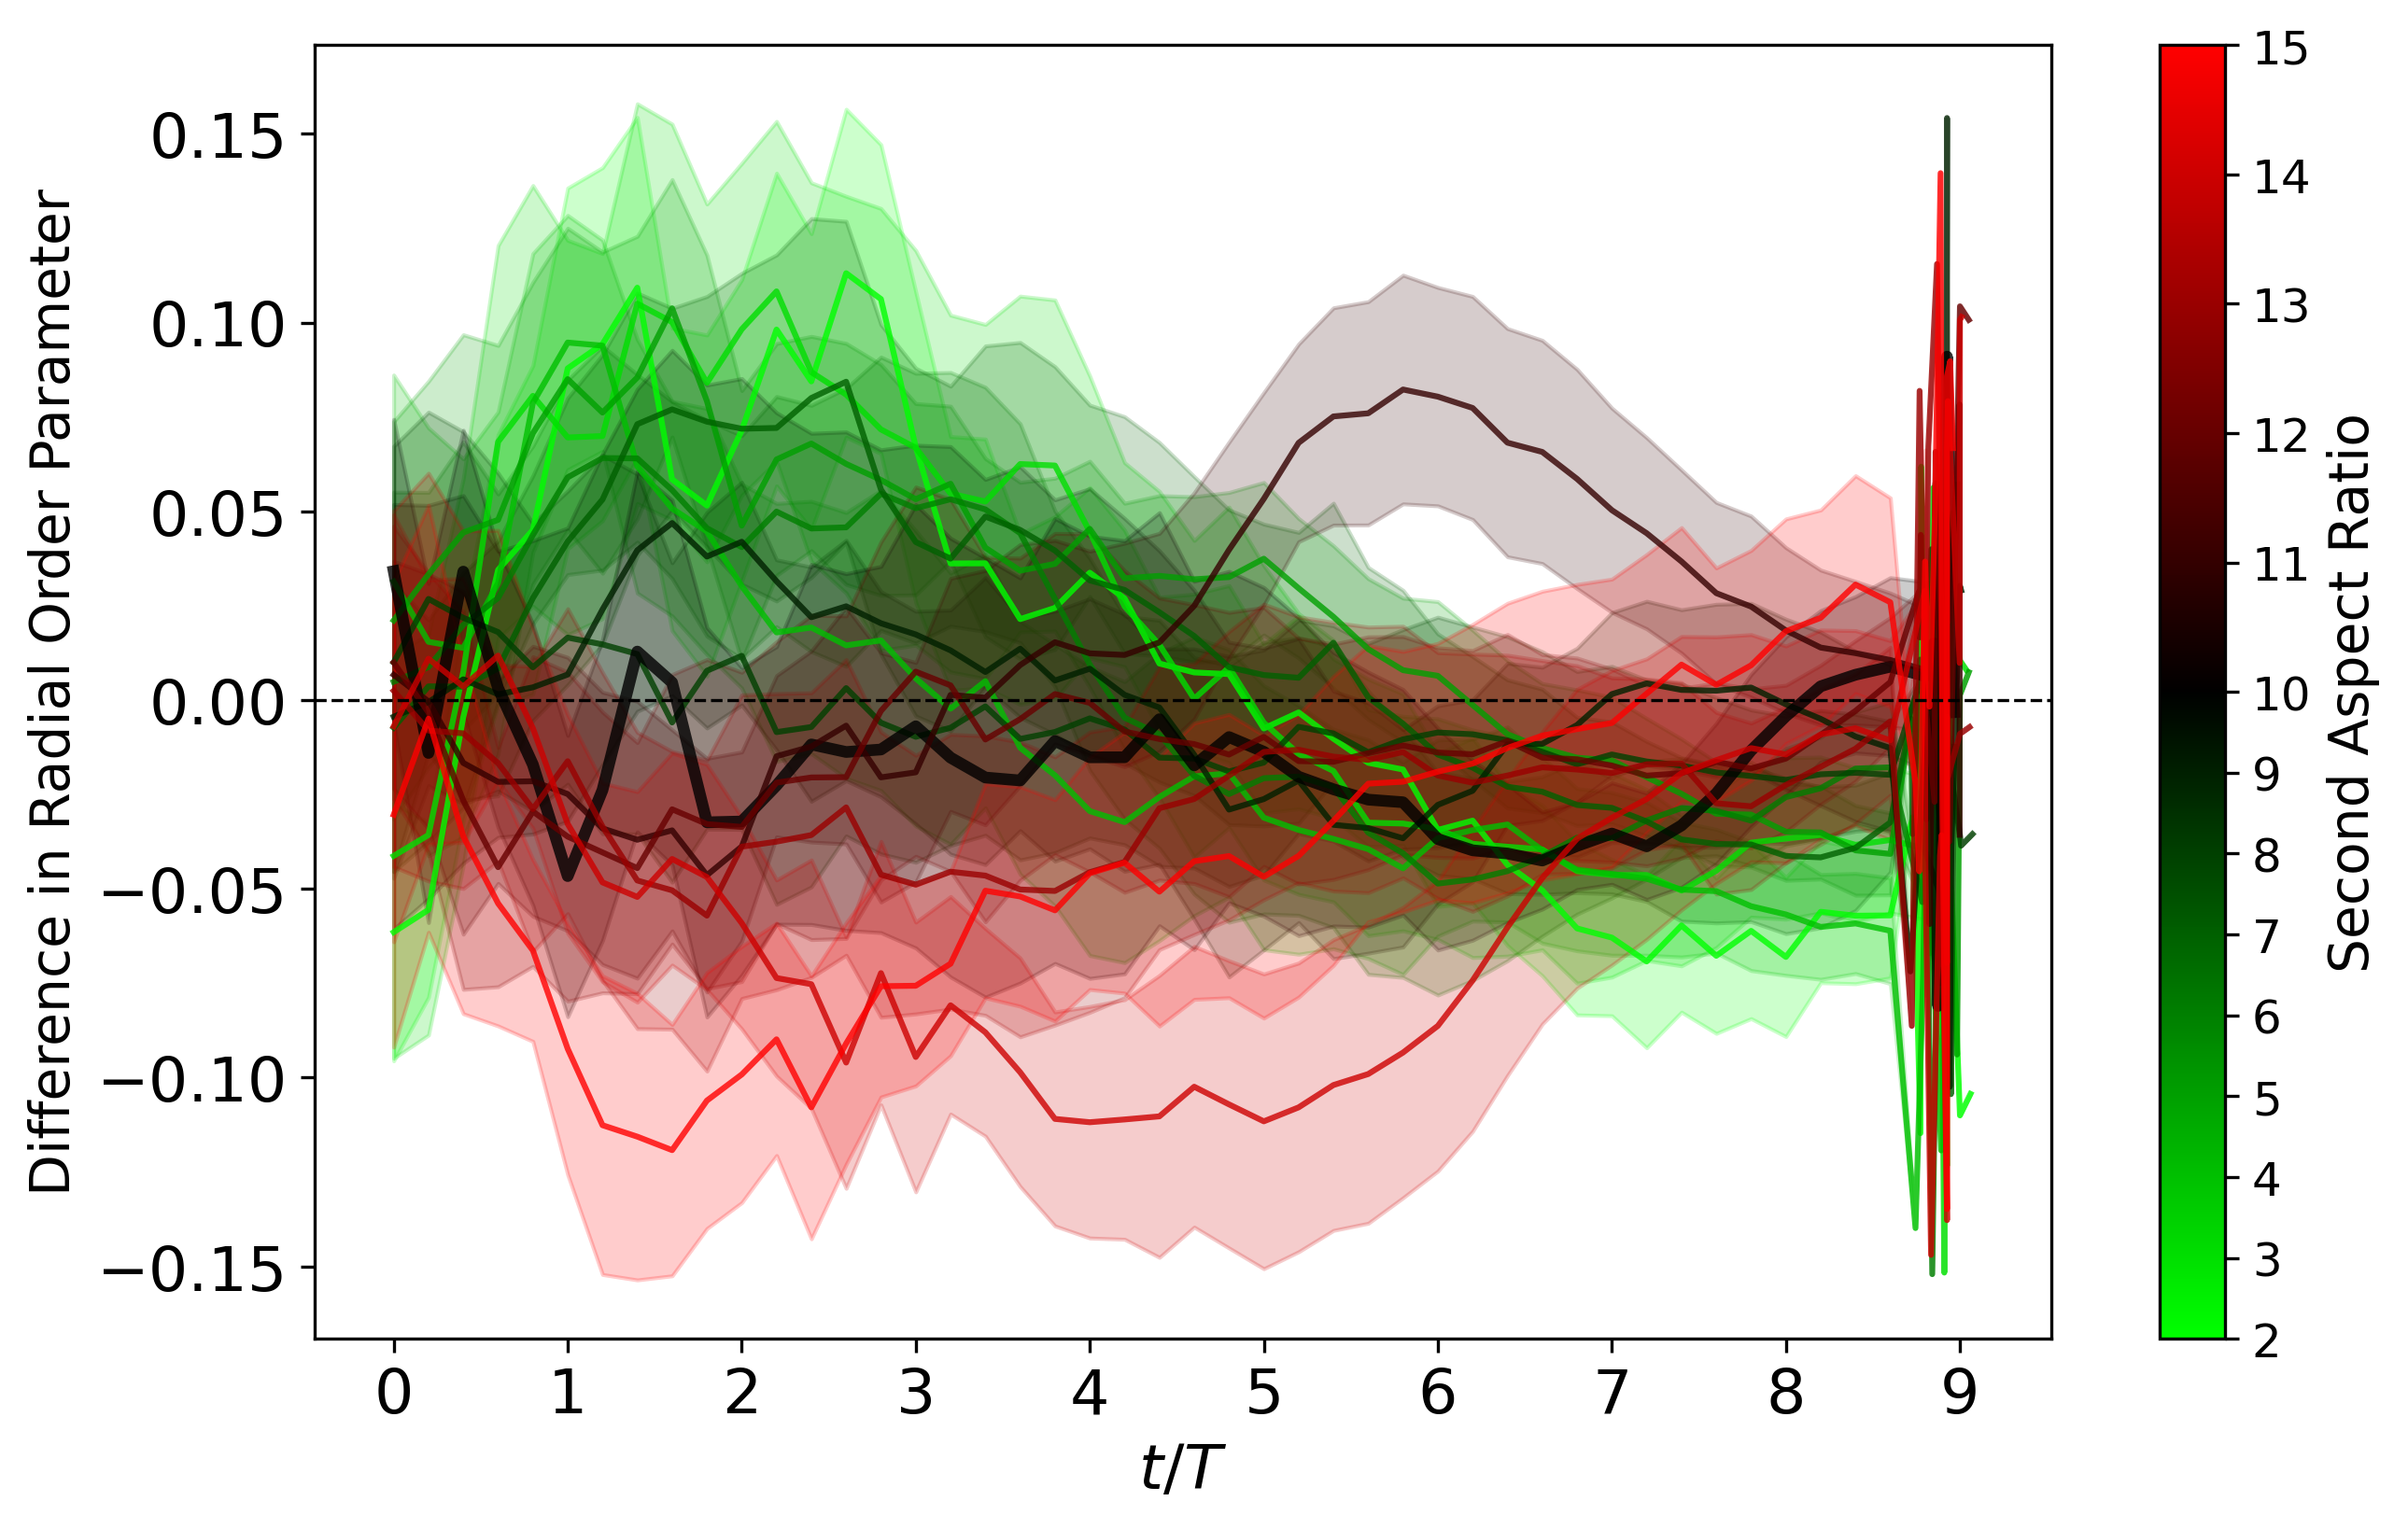

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import pandas as pd
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import re


def create_black_centered_cmap():
    colors = ["#00FF00", "black", "#FF0000"]
    cmap = LinearSegmentedColormap.from_list("black_centered", colors, N=500)
    return cmap

def extract_aspect_ratios_from_path(path):
    match = re.search(r'(division_lengths|MAR):([\d.]+),([\d.]+)', path)
    if match:
        asp1 = round(float(match.group(2)) / 0.1, 0) if match.group(1) == 'division_lengths' else float(match.group(2))
        asp2 = round(float(match.group(3)) / 0.1, 0) if match.group(1) == 'division_lengths' else float(match.group(3))
        return asp1, asp2
    raise ValueError("Neither 'division_lengths' nor 'MAR' found in path")


results_per_aspect_ratio = {}

thickness = 0.1
max_length = 0


aspect_times = {}

aspect_folders = ['asp10', 'asp2', 'asp3', 'asp4', 'asp5', 'asp6', 'asp7', 'asp8', 'asp9', 'asp11', 'asp12', 'asp13', 'asp14', 'asp15']

for trial in range(1, 6):
    for aspect_folder in aspect_folders:
        trial_path = f"/home/mratman1/activeMatterCommunities/workspace/simulations_eqdivtime/{aspect_folder}/run{trial}"
        subfolders = [f.path for f in os.scandir(trial_path) if f.is_dir()]

        for subfolder in subfolders:
            asp1, asp2 = extract_aspect_ratios_from_path(subfolder)
            if asp1 == 10.0 or asp2 == 10.0:
                filenames = os.listdir(subfolder)
                csv_files = [f for f in filenames if f.endswith('.csv')]
                if not csv_files:
                    continue  

                time_values = sorted([int(f.strip('.csv')) for f in csv_files if f[0].isdigit()])
                time_values_scaled = [t / 20e5 for t in time_values]

                radial_cor1_list = []
                radial_cor2_list = []

                for time in time_values:
                    df = pd.read_csv(f"{subfolder}/{time}.csv", header=0)
                    x, y, ex, ey = df[["x", "y", "ex", "ey"]].T.values
                    length, color, color2 = df[["l", "color", "color2"]].T.values

                    radialcor1 = []
                    radialcor2 = []

                    for i in range(np.size(x)):
                        theta = math.atan2(ey[i], ex[i])
                        phi = math.atan2(y[i], x[i])
                        if color2[i] == 0:
                            radialcor1.append(np.cos(2 * (theta - phi)))
                        elif color2[i] == 1:
                            radialcor2.append(np.cos(2 * (theta - phi)))

                    avg_radial_cor1 = np.mean(radialcor1) if radialcor1 else 0
                    avg_radial_cor2 = np.mean(radialcor2) if radialcor2 else 0

                    radial_cor1_list.append(avg_radial_cor1)
                    radial_cor2_list.append(avg_radial_cor2)

                max_length = max(max_length, len(radial_cor1_list))
                radial_cor1_list += [0] * (max_length - len(radial_cor1_list))
                radial_cor2_list += [0] * (max_length - len(radial_cor2_list))

                
                if asp1 == 10.0:
                    aspect_ratio_key = (10.0, asp2)  
                    if aspect_ratio_key not in results_per_aspect_ratio:
                        results_per_aspect_ratio[aspect_ratio_key] = {
                            "radial_cor1": [], "radial_cor2": [], "times": []
                        }
                    results_per_aspect_ratio[aspect_ratio_key]["radial_cor1"].append(radial_cor1_list)
                    results_per_aspect_ratio[aspect_ratio_key]["radial_cor2"].append(radial_cor2_list)
                    results_per_aspect_ratio[aspect_ratio_key]["times"].append(time_values_scaled)

                elif asp2 == 10.0:
                    aspect_ratio_key = (10.0, asp1) 
                    if aspect_ratio_key not in results_per_aspect_ratio:
                        results_per_aspect_ratio[aspect_ratio_key] = {
                            "radial_cor1": [], "radial_cor2": [], "times": []
                        }
                    results_per_aspect_ratio[aspect_ratio_key]["radial_cor1"].append(radial_cor2_list)
                    results_per_aspect_ratio[aspect_ratio_key]["radial_cor2"].append(radial_cor1_list)
                    results_per_aspect_ratio[aspect_ratio_key]["times"].append(time_values_scaled)


averaged_results = {}

for key, data in results_per_aspect_ratio.items():
    all_times = sorted(set(time for trial_times in data["times"] for time in trial_times))
    avg_diff_radial_cor = []
    sem_diff_radial_cor = []

    for time in all_times:
        trial_diff_radial_cor = []

        for trial_idx, trial_times in enumerate(data["times"]):
            if time in trial_times:
                index = trial_times.index(time)
                diff_radial_cor = data["radial_cor1"][trial_idx][index] - data["radial_cor2"][trial_idx][index]
                trial_diff_radial_cor.append(diff_radial_cor)

        avg_diff_radial_cor.append(np.mean(trial_diff_radial_cor))
        sem_diff_radial_cor.append(np.std(trial_diff_radial_cor) / np.sqrt(len(trial_diff_radial_cor)))

    averaged_results[key] = {
        "avg_diff_radial_cor": avg_diff_radial_cor, "sem_diff_radial_cor": sem_diff_radial_cor,
        "times": all_times
    }


filtered_aspects = {key: val for key, val in averaged_results.items() if key[0] == 10 and 2 <= key[1] <= 15}

if not filtered_aspects:
    print("No aspect ratios found where the first aspect ratio is 10 and the second aspect ratio is between 2 and 15.")
else:
    sorted_aspects = dict(sorted(filtered_aspects.items(), key=lambda x: x[0][1]))

    
    fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
    color_map = create_black_centered_cmap()
    norm = mcolors.TwoSlopeNorm(vmin=2, vcenter=10, vmax=15)  

    sm = plt.cm.ScalarMappable(cmap=color_map, norm=norm)
    sm.set_array([])

    for idx, ((asp1, asp2), data) in enumerate(sorted_aspects.items()):
        times = data["times"]
        avg_diff_radial_cor = data["avg_diff_radial_cor"]
        sem_diff_radial_cor = data["sem_diff_radial_cor"]

        if (asp1, asp2) == (10, 10):
            color = 'black'
            line_width = 3.0
            label = 'ASP2 = 10 (equal aspect ratio)'
        else:
            color = color_map(norm(asp2))
            line_width = 1.5
            label = f"ASP2 = {asp2}"

        
        ax.plot(times, avg_diff_radial_cor, color=color, alpha=0.8, label=label, linewidth=line_width)
        ax.fill_between(
            times, 
            np.array(avg_diff_radial_cor) - np.array(sem_diff_radial_cor), 
            np.array(avg_diff_radial_cor) + np.array(sem_diff_radial_cor), 
            color=color, 
            alpha=0.2
        )

    ax.set_xlabel(r"$t/T$", fontsize=16)
    ax.set_xlim(0, 8.6)  
    ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8])
    ax.axhline(0.0, color='black', linestyle='--', linewidth=0.8)
    ax.set_ylabel(r"Difference in Radial Order Parameter", fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=16)

    
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical')
    cbar.set_label('Second Aspect Ratio', fontsize=14)
    cbar.ax.tick_params(labelsize=12)
    cbar.set_ticks(np.arange(2, 16, 1))
    cbar.set_ticklabels([str(i) for i in range(2, 16)])

    plt.savefig("GRAPH_FOR_DIFF_RADIAL_COR_ASP10_COLORBAR.png", bbox_inches='tight', dpi=300)
    plt.show()


## Average

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import pandas as pd
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import re


def create_black_centered_cmap():
    
    colors = ["#00FF00", "black", "#FF0000"]
    
    cmap = LinearSegmentedColormap.from_list("black_centered", colors, N=500)
    return cmap

def extract_aspect_ratios_from_path(path):
    match = re.search(r'(division_lengths|MAR):([\d.]+),([\d.]+)', path)
    if match:
        asp1 = round(float(match.group(2)) / 0.1, 0) if match.group(1) == 'division_lengths' else float(match.group(2))
        asp2 = round(float(match.group(3)) / 0.1, 0) if match.group(1) == 'division_lengths' else float(match.group(3))
        return asp1, asp2
    raise ValueError("Neither 'division_lengths' nor 'MAR' found in path")


results_per_aspect_ratio = {}

thickness = 0.1
max_length = 0




aspect_times = {}

aspect_folders = ['asp10', 'asp2', 'asp3', 'asp4', 'asp5', 'asp6', 'asp7', 'asp8', 'asp9', 'asp11', 'asp12', 'asp13', 'asp14', 'asp15']

for trial in range(1, 6):
    for aspect_folder in aspect_folders:
        trial_path = f"/home/mratman1/activeMatterCommunities/workspace/simulations_eqdivtime/{aspect_folder}/run{trial}"
        subfolders = [f.path for f in os.scandir(trial_path) if f.is_dir()]

        for subfolder in subfolders:
            asp1, asp2 = extract_aspect_ratios_from_path(subfolder)
            if asp1 == 10.0 or asp2 == 10.0:
                filenames = os.listdir(subfolder)
                
                csv_files = [f for f in filenames if f.endswith('.csv')]
                if not csv_files:
                    continue  

                time_values = sorted([int(f.strip('.csv')) for f in csv_files if f[0].isdigit()])

                
                time_values_scaled = [t / 20e5 for t in time_values]

                
                combined_radial_cor_list = []

                for time in time_values:
                    df = pd.read_csv(f"{subfolder}/{time}.csv", header=0)
                    x, y, ex, ey = df[["x", "y", "ex", "ey"]].T.values
                    length, color, color2 = df[["l", "color", "color2"]].T.values

                    radial_cor = []
                
                    for i in range(np.size(x)):
                        theta = math.atan2(ey[i], ex[i])
                        phi = math.atan2(y[i], x[i])
                        radial_cor.append(np.cos(2 * (theta - phi)))

                    avg_radial_cor = np.mean(radial_cor) if radial_cor else 0
                    combined_radial_cor_list.append(avg_radial_cor)

                
                max_length = max(max_length, len(combined_radial_cor_list))
                combined_radial_cor_list += [0] * (max_length - len(combined_radial_cor_list))

                
                asp1_lengths = [length[i] for i in range(len(length)) if color2[i] == 0]
                asp2_lengths = [length[i] for i in range(len(length)) if color2[i] == 1]
                
                Asp_1max = asp1
                Asp_2max = asp2 

                if asp1 == 10.0:
                    aspect_ratio_key = (10.0, asp2)  

                elif asp2 == 10.0:
                    aspect_ratio_key = (10.0, asp1) 

                if aspect_ratio_key not in results_per_aspect_ratio:
                    results_per_aspect_ratio[aspect_ratio_key] = {
                        "combined_radial_cor": [], "times": []
                    }
                results_per_aspect_ratio[aspect_ratio_key]["combined_radial_cor"].append(combined_radial_cor_list)
                results_per_aspect_ratio[aspect_ratio_key]["times"].append(time_values_scaled)
            else:
                continue


averaged_results = {}

for key, data in results_per_aspect_ratio.items():
    
    all_times = sorted(set(time for trial_times in data["times"] for time in trial_times))
    avg_combined_radial_cor = []
    sem_combined_radial_cor = []
    
    for time in all_times:
        trial_combined_radial_cor = []
        
        for trial_idx, trial_times in enumerate(data["times"]):
            if time in trial_times:
                index = trial_times.index(time)
                combined_radial_cor = data["combined_radial_cor"][trial_idx][index]
                trial_combined_radial_cor.append(combined_radial_cor)
        
        avg_combined_radial_cor.append(np.mean(trial_combined_radial_cor))
        sem_combined_radial_cor.append(np.std(trial_combined_radial_cor) / np.sqrt(len(trial_combined_radial_cor)))
    
    averaged_results[key] = {
        "avg_combined_radial_cor": avg_combined_radial_cor, "sem_combined_radial_cor": sem_combined_radial_cor,
        "times": all_times
    }


filtered_aspects = {key: val for key, val in averaged_results.items() if key[0] == 10 and 2 <= key[1] <= 15}

if not filtered_aspects:
    print("No aspect ratios found where the first aspect ratio is 10 and the second aspect ratio is between 2 and 15.")
else:
    
    sorted_aspects = dict(sorted(filtered_aspects.items(), key=lambda x: x[0][1]))

    
    fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

    
    color_map = create_black_centered_cmap()
    norm = mcolors.TwoSlopeNorm(vmin=2, vcenter=10, vmax=15)  

    sm = plt.cm.ScalarMappable(cmap=color_map, norm=norm)
    sm.set_array([])

    for idx, ((asp1, asp2), data) in enumerate(sorted_aspects.items()):
        times = data["times"]
        avg_combined_radial_cor = data["avg_combined_radial_cor"]
        sem_combined_radial_cor = data["sem_combined_radial_cor"]

        
        if (asp1, asp2) == (10, 10):
            color = 'black'
            line_width = 2.5  
            label = 'ASP2 = 10 (equal aspect ratio)'
        else:
            color = color_map(norm(asp2))
            line_width = 1.5  
            label = f"ASP2 = {asp2}"

        
        ax.plot(times, avg_combined_radial_cor, color=color, alpha=0.8, label=label, linewidth=line_width)
        ax.fill_between(
            times, 
            np.array(avg_combined_radial_cor) - np.array(sem_combined_radial_cor), 
            np.array(avg_combined_radial_cor) + np.array(sem_combined_radial_cor), 
            color=color, 
            alpha=0.2  
        )

    ax.set_xlabel(r"$t/T$", fontsize=16)
    ax.set_xlim(0, 8.6)  
    ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8])
    ax.set_ylabel(r"Average Radial Order Parameter", fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.axhline(0.0, color='black', linestyle='--', linewidth=0.8)

    
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical')
    cbar.set_label('Second Aspect Ratio', fontsize=14)
    cbar.ax.tick_params(labelsize=12)
    cbar.set_ticks(np.arange(2, 16, 1))  
    cbar.set_ticklabels([str(i) for i in range(2, 16)])  

    plt.savefig("GRAPH_FOR_COMBINED_RADIAL_COR_ASP10_COLORBAR.png", bbox_inches='tight', dpi=300)
    plt.show()


ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

## Spatial 

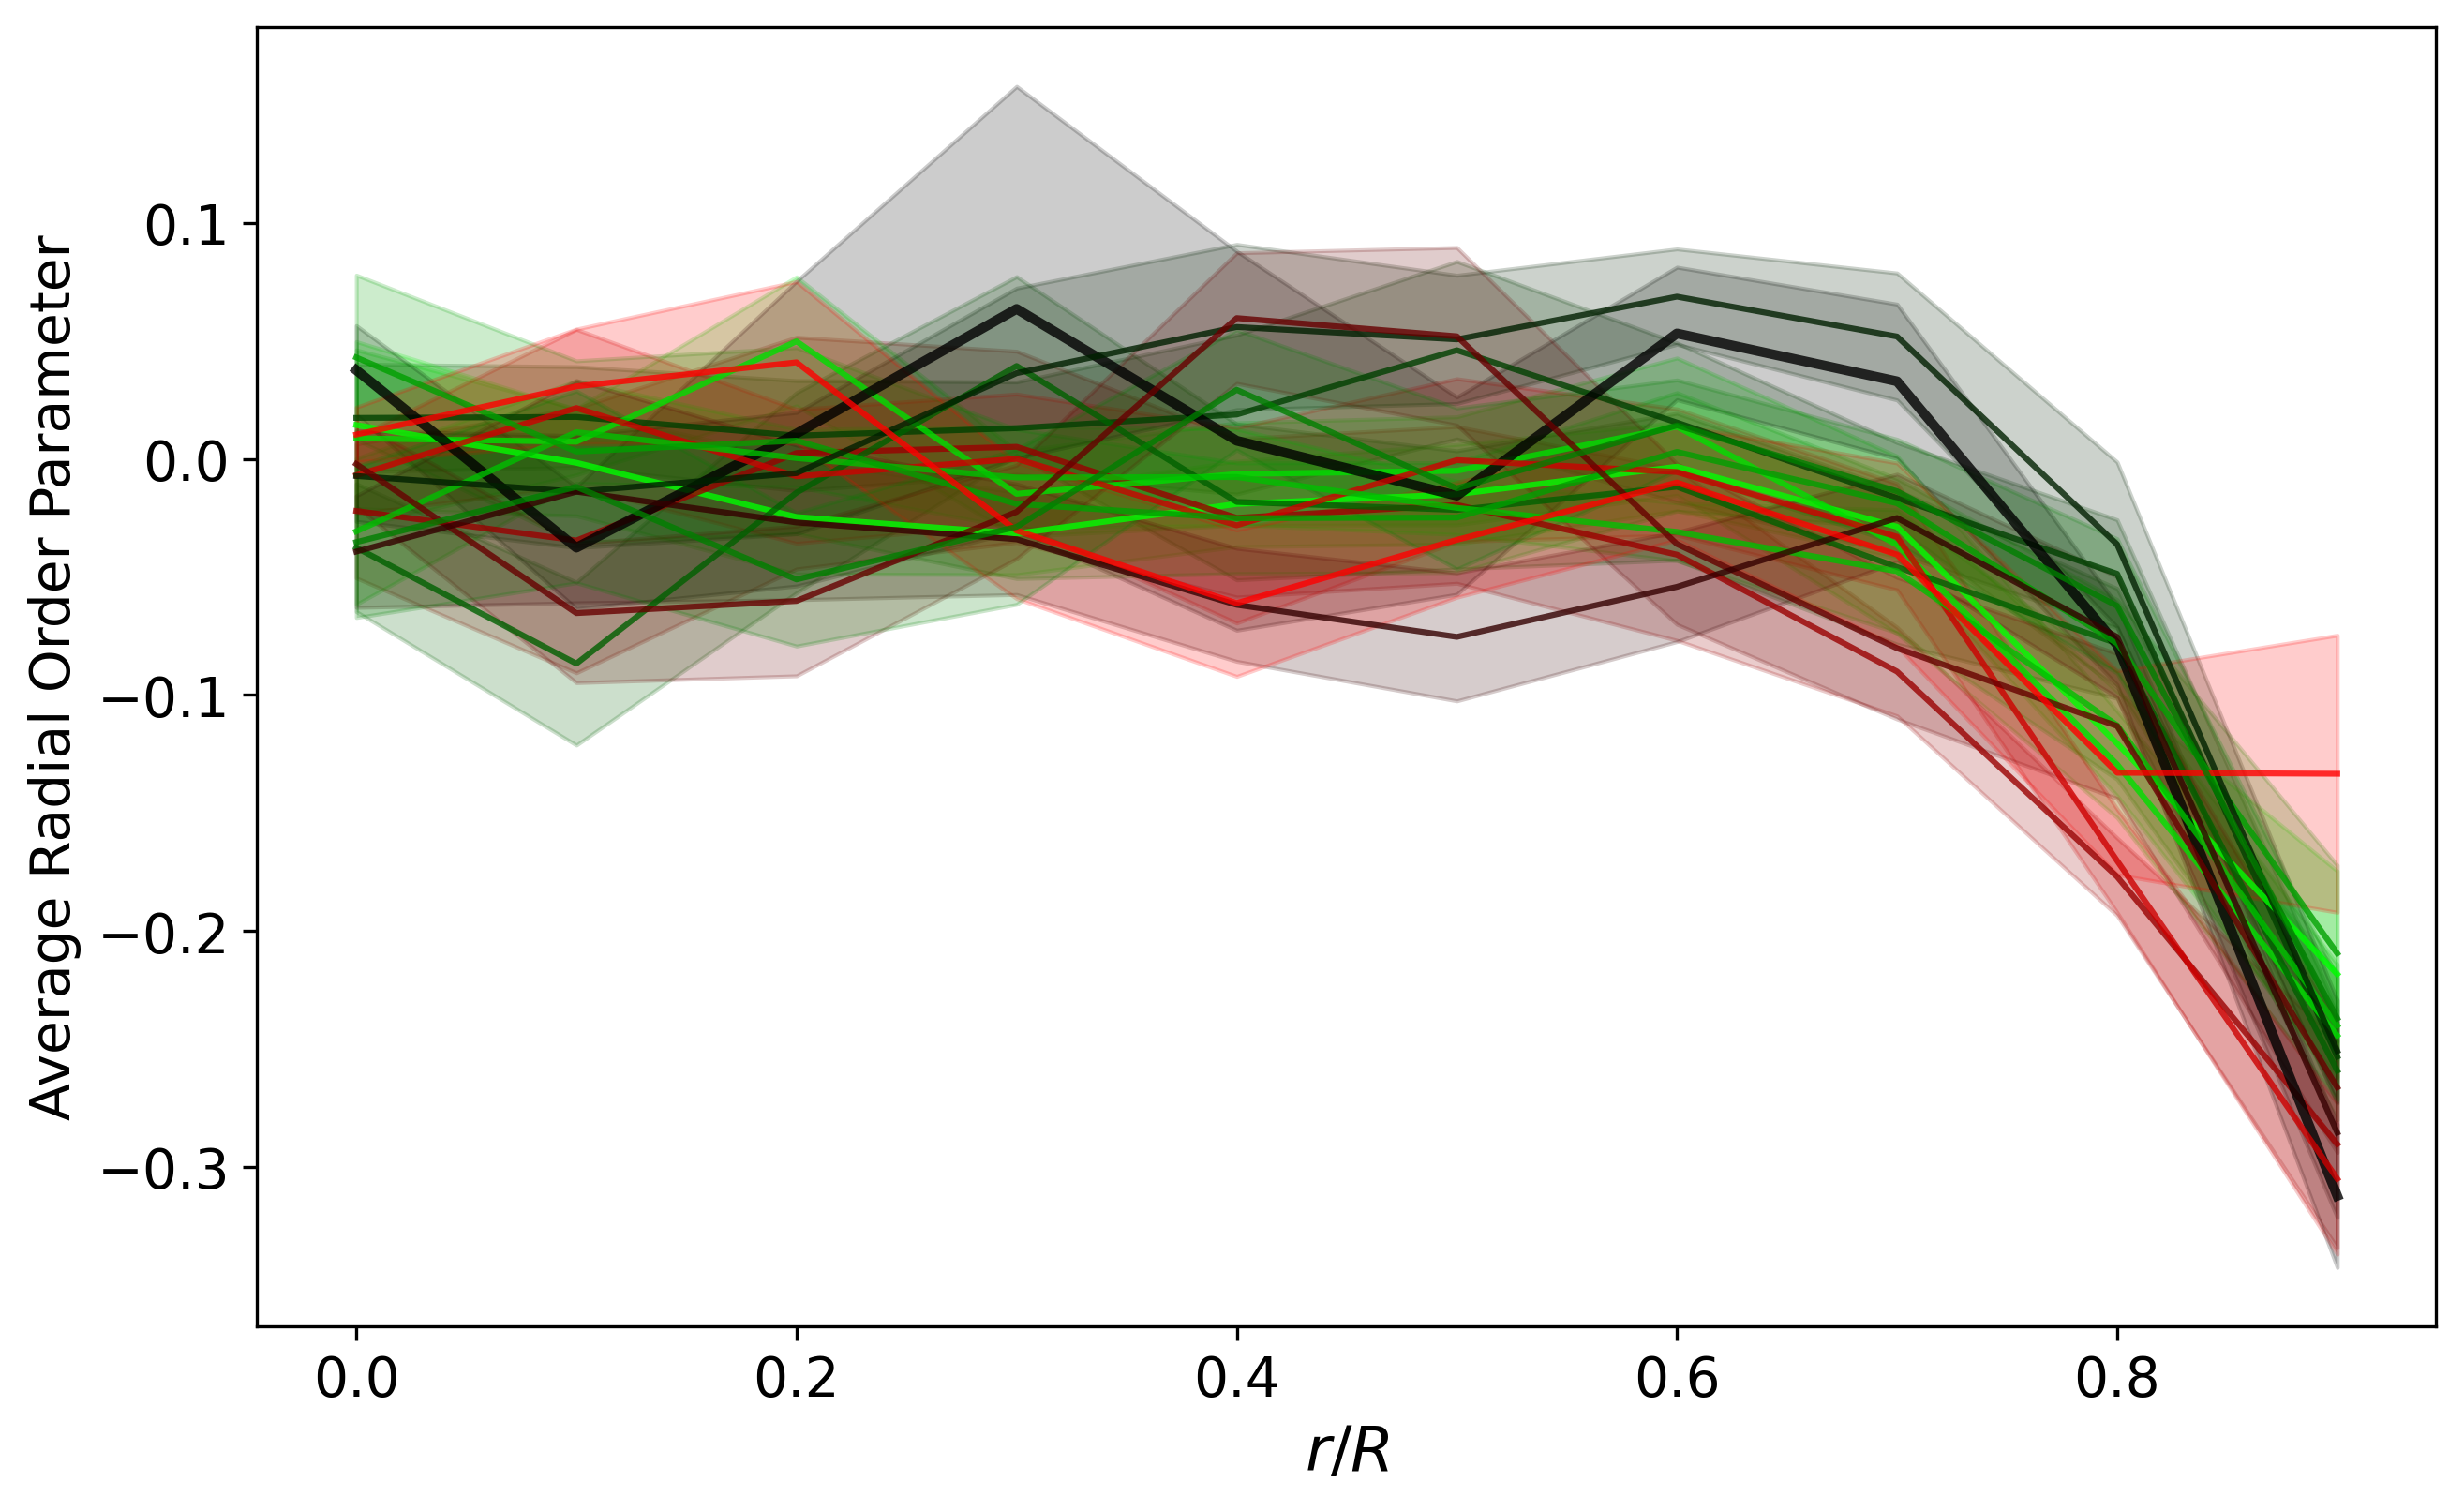

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap


def create_black_centered_cmap():
    colors = ["#00FF00", "black", "#FF0000"]
    cmap = LinearSegmentedColormap.from_list("black_centered", colors, N=500)
    return cmap

def extract_aspect_ratios_from_path(path):
    match = re.search(r'(division_lengths|MAR):([\d.]+),([\d.]+)', path)
    if match:
        asp1 = round(float(match.group(2)) / 0.1, 0) if match.group(1) == 'division_lengths' else float(match.group(2))
        asp2 = round(float(match.group(3)) / 0.1, 0) if match.group(1) == 'division_lengths' else float(match.group(3))
        return asp1, asp2
    raise ValueError("Neither 'division_lengths' nor 'MAR' found in path")


results_per_aspect_ratio = {}

thickness = 0.1

aspect_folders = ['asp10', 'asp2', 'asp3', 'asp4', 'asp5', 'asp6', 'asp7', 'asp8', 'asp9', 'asp11', 'asp12', 'asp13', 'asp14', 'asp15']

for trial in range(1, 6):
    for aspect_folder in aspect_folders:
        trial_path = f"/home/mratman1/activeMatterCommunities/workspace/simulations_eqdivtime/{aspect_folder}/run{trial}"
        subfolders = [f.path for f in os.scandir(trial_path) if f.is_dir()]

        for subfolder in subfolders:
            asp1, asp2 = extract_aspect_ratios_from_path(subfolder)
            if asp1 == 10.0 or asp2 == 10.0:
                filenames = os.listdir(subfolder)
                
                csv_files = [f for f in filenames if f.endswith('.csv')]
                if not csv_files:
                    continue  

                time_values = sorted([int(f.strip('.csv')) for f in csv_files if f[0].isdigit()])

                
                time_values_scaled = [t / 5e5 for t in time_values]

                
                
                last_time_file = sorted(time_values)[-1]

                df = pd.read_csv(f"{subfolder}/{last_time_file}.csv", header=0)
                
                
                
                required_columns = ["x", "y", "ex", "ey", "l", "color", "color2"]
                if not all(col in df.columns for col in required_columns):
                    print(f"Columns missing in {last_time_file}")
                    continue

                x, y, ex, ey = df[["x", "y", "ex", "ey"]].T.values
                length = df["l"].values

                
                if asp1 == 10.0:
                    aspect_ratio_key = (10.0, asp2)  

                elif asp2 == 10.0:
                    aspect_ratio_key = (10.0, asp1) 

                
                radial_cor = []
                
                for i in range(len(x)):
                    theta = np.arctan2(ey[i], ex[i])
                    phi = np.arctan2(y[i], x[i])
                    radial_cor.append(np.cos(2 * (theta - phi)))

                avg_radial_cor = np.mean(radial_cor) if radial_cor else 0

                
                center_of_mass = np.array([np.mean(x), np.mean(y)])

                
                distances = np.linalg.norm(np.array([x, y]).T - center_of_mass, axis=1)

                
                R = np.max(distances)

                
                bins = np.linspace(0, R, 11)  
                digitized = np.digitize(distances, bins)  

                binned_radial_cor = np.zeros(len(bins) - 1)
                counts = np.zeros(len(bins) - 1)

                for idx in range(len(distances)):
                    
                    if digitized[idx] > 0 and digitized[idx] < len(binned_radial_cor) + 1:  
                        binned_radial_cor[digitized[idx] - 1] += radial_cor[idx]
                        counts[digitized[idx] - 1] += 1

                
                with np.errstate(divide='ignore', invalid='ignore'):
                    avg_binned_radial_cor = np.divide(binned_radial_cor, counts, where=counts != 0)

                
                if aspect_ratio_key not in results_per_aspect_ratio:
                    results_per_aspect_ratio[aspect_ratio_key] = []
                results_per_aspect_ratio[aspect_ratio_key].append(avg_binned_radial_cor)


averaged_results = {}

for key, binned_data in results_per_aspect_ratio.items():
    avg_binned_radial_cor = np.mean(binned_data, axis=0)
    sem_binned_radial_cor = np.std(binned_data, axis=0) / np.sqrt(len(binned_data))
    averaged_results[key] = {
        "avg_binned_radial_cor": avg_binned_radial_cor,
        "sem_binned_radial_cor": sem_binned_radial_cor,
        "bins": bins[:-1] / R  
    }


fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
color_map = create_black_centered_cmap()
norm = mcolors.TwoSlopeNorm(vmin=2, vcenter=10, vmax=15)  

for key, data in averaged_results.items():
    avg_radial_order_param = data["avg_binned_radial_cor"]
    sem_radial_order_param = data["sem_binned_radial_cor"]
    r_normalized = data["bins"]

    
    asp1, asp2 = key
    if (asp1, asp2) == (10, 10):
        color = 'black'
        line_width = 2.5
    else:
        color = color_map(norm(asp2))
        line_width = 1.5

    
    ax.plot(r_normalized, avg_radial_order_param, color=color, alpha=0.8, linewidth=line_width)
    ax.fill_between(
        r_normalized,
        avg_radial_order_param - sem_radial_order_param,
        avg_radial_order_param + sem_radial_order_param,
        color=color,
        alpha=0.2
    )

ax.set_xlabel(r"$r/R$", fontsize=16)
ax.set_ylabel(r"Average Radial Order Parameter", fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)



plt.savefig("GRAPH_FOR_RADIAL_ORDER_PARAMETER.png", bbox_inches='tight', dpi=300)
plt.show()
